In [122]:
cells_order = rev(c('proliferative', 'KRT5_LRG6', 'Inter_PGRneg', 'KRT5_KRT13', 
                                              'Inter_PGRpos', 'Secretory', 
                                              'Ciliated_G2M', 'Ciliated'))

#  Plot CellphoneDB

In [123]:
library(dplyr)
library(reshape2)
library(plyr)
library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)

get_cells2genes = function(CPresults, genes2filter = NULL){
    if( ! is.null(genes2filter) ){
        CPresults = CPresults[ sapply(rownames(CPresults), function(x) any(unlist(Int2Gene[[x]]) %in%  genes2filter) ), ]
        CPresults = CPresults[ , apply(CPresults, 2, sum) > 0]
    }
    # reformat as dataframe                                    
    df = melt(as.matrix(CPresults))
    df = subset(df, value == 1)
    # extract interaction partners
    xA = apply(df, 1, function(x){
        data.frame(cell = strsplit(x[2], '--')[[1]][1],
            gene = Int2Gene[[x[1]]]$partner_a)
    })
    xB = apply(df, 1, function(x){
        data.frame(cell = strsplit(x[2], '--')[[1]][2],
            gene = Int2Gene[[x[1]]]$partner_b)
    })
    x = append(xA, xB)
    # Merge as data frame for plotting with ggplot
    cells2genesCP = melt(x, id.vars = names(x[[1]]))
    cells2genesCP = unique(cells2genesCP[,-3])
    # transfer expression info                                  
    cells2genesCP$id = paste(cells2genesCP$cell, cells2genesCP$gene)
    cells2genesCP$AveExpr_cluster =  PERC$AveExpr_cluster[ match(cells2genesCP$id, PERC$id) ]
    cells2genesCP$percentExpr_cluster =  PERC$percentExpr_cluster[ match(cells2genesCP$id, PERC$id) ]

    return(cells2genesCP)
}

# Load Cellphone Genes

In [124]:
# Define variables
filter_int_user_curated = T #Use only user_curated interactions?
per_cutoff = 0.1 # min % of cells in the cluster required  with expression > 0 for the gene
pval_cutoff = 0.001 # max adjusted p-value requeired to consider a gene as DEG
logFC_cutoff = 0 # min logFC to consider a gene as DEG

In [125]:
# Load cellphone database - genes and complexes file
# Gene names
genes_cpDB = read.delim('~/cellphoneDB/hsa_uniprot.txt', stringsAsFactors = F, sep = '\t')

# Complexes members
com_cpDB = read.csv('~/farm/CellPhoneDB-data_smallmolecules/data/sources/complex_curated.csv', stringsAsFactors = F)
com_cpDB = unique(com_cpDB)
com_cpDB$complex_name = paste0('complex:', com_cpDB$complex_name)
# Generate complexes2gene symbol dictionary
Com2Gene = lapply(com_cpDB$complex_name, function(cx) subset(genes_cpDB, uniprot %in% unlist(com_cpDB[com_cpDB$complex_name == cx, 2:5]) )$gene_name )
Com2Gene = lapply(Com2Gene, unique)
names(Com2Gene) = com_cpDB$complex_name
                  
# Load interactions from cellphoneDB/out/means.txt output file                   
int_cpDB = read.delim('data/cellphoneDB_organoids_NI/out/means.txt', stringsAsFactors = F)[, 1:10]
# MANDATORY: remove "curated" because we have cleaned and renamed them (this is a long story, just do it)
int_cpDB = subset(int_cpDB, annotation_strategy != 'curated')
# OPTIONAL: Use only user_curated interactions?
if(filter_int_user_curated)
    int_cpDB = subset(int_cpDB, annotation_strategy == 'user_curated')
# Generate Int2Gene dictionary
Int2Gene = apply(int_cpDB, 1, function(int) {
    int = unname(int)
    if(int[5] == '') # if partnerA is complex, then retrieve members from dictionary
       partnerA = Com2Gene[[int[3]]]
    else  # if partnerA is a single gene, take name from file
       partnerA = int[5]
    if(int[6] == '')  # if partnerB is complex, then retrieve members from dictionary
       partnerB = Com2Gene[[int[4]]]
    else  # if partnerB is a single gene, take name from file
       partnerB = int[6]
    list(partner_a=partnerA,partner_b=partnerB)
    }) 
names(Int2Gene) = int_cpDB$interacting_pair

# Load expression information

In [126]:
# Load percentage expression info
# you need to put in a folder a file for each cluster that you included in cellphone
# The file must contain at least three columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - percentExpr_cluster: % of cells in the cluster with expression > 0 for the gene
path_Exp = '/home/jovyan/farm/endometrium/data/cellphoneDB_organoids_NI/Perc/'

# Load
Per_files = list.files(path_Exp, pattern = 'DEGs.csv', full.names = T)
Per_df = lapply(Per_files, read.csv, stringsAsFactors = F) 

# Set rownames as genes, for convenience
Per_df = lapply(Per_df, function(x){ 
    rownames(x) = x$Gene
    return(x) })

# Remove genes not in cellphone
Per_df = lapply(Per_df, function(x) subset(x, Gene %in% genes_cpDB$gene_name ))
                
# Build dictionary clusters2expressed genes                       
names(Per_df) = sapply(Per_df, function(x) x$cluster[1])
PERC = melt(Per_df, id.vars = names(Per_df[[1]]))
PERC$id = paste(PERC$cluster, PERC$Gene)                      
head(PERC)
                       

,cluster,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,L1,id
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,Ciliated,DCDC2B,0.7724271,0,0,0.860831,0.031259,0.6250,0.031322,Ciliated,Ciliated DCDC2B
2,Ciliated,PLAC8,0.6970496,0,0,0.754738,0.018631,0.4825,0.020233,Ciliated,Ciliated PLAC8
3,Ciliated,OMG,0.9115348,0,0,1.155176,0.115667,0.7135,0.093966,Ciliated,Ciliated OMG
4,Ciliated,SERPINA6,0.6974126,0,0,0.802669,0.043183,0.5395,0.045003,Ciliated,Ciliated SERPINA6
5,Ciliated,CD164L2,0.9639251,0,0,1.308323,0.177630,0.7775,0.142065,Ciliated,Ciliated CD164L2
6,Ciliated,FAM166B,0.8826226,0,0,1.170073,0.139930,0.7365,0.109447,Ciliated,Ciliated FAM166B


## Load cellphone results file - MEDIA

In [127]:
CPresults = read.csv('data/cellphoneDB_organoids_NI/out/DEapproach_results_pval0.001_logFC0_withMedia.csv', stringsAsFactors = F)
rownames(CPresults) = CPresults$X
CPresults = CPresults[, -1]
colnames(CPresults) = gsub('\\...', '--', colnames(CPresults))
head(CPresults)

,Ciliated_G2M--Media,Inter_PGRneg--Media,Inter_PGRpos--Media,KRT5_KRT13--Media,Media--Secretory,Media--Inter_PGRpos,Media--KRT5_LRG6,proliferative--Media,Secretory--Media
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
FGF10_FGFR2,0,0,0,0,0,1,0,0,0
EGFR_EGF,1,0,0,1,0,0,0,0,0
RSPO1_LGR4,0,0,0,0,1,1,0,0,0
RSPO1_LGR6,0,0,0,0,0,0,1,0,0
LGR5_RSPO1,0,0,1,0,0,0,0,1,1
MET_HGF,0,1,1,1,0,0,0,1,1


# Dotplot1

Dot Plot 1: Receptors for media factors



### Load genes of interest

In [128]:
genes2plot = read.csv('data/cellphoneDB_organoids_NI/genes2plot/dotplot_media.txt', stringsAsFactors = F, sep = '\t', header = F)$V1
genes2plot

[1] "RSPO1" "HGF"   "FGF10" "EGF"   "NOG"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [129]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
cells2genes$value = 1
cells2genes$gene = as.character(cells2genes$gene)
cells2genes$cell = as.character(cells2genes$cell)
 
head(cells2genes)

,cell,gene,id,AveExpr_cluster,percentExpr_cluster,value
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Ciliated_G2M,EGFR,Ciliated_G2M EGFR,0.258946,0.290254,1
2,Inter_PGRneg,MET,Inter_PGRneg MET,0.509796,0.498500,1
3,Inter_PGRpos,LGR5,Inter_PGRpos LGR5,0.262217,0.296000,1
4,Inter_PGRpos,MET,Inter_PGRpos MET,0.503543,0.516500,1
5,KRT5_KRT13,EGFR,KRT5_KRT13 EGFR,0.410910,0.456500,1
6,KRT5_KRT13,MET,KRT5_KRT13 MET,0.627707,0.595000,1


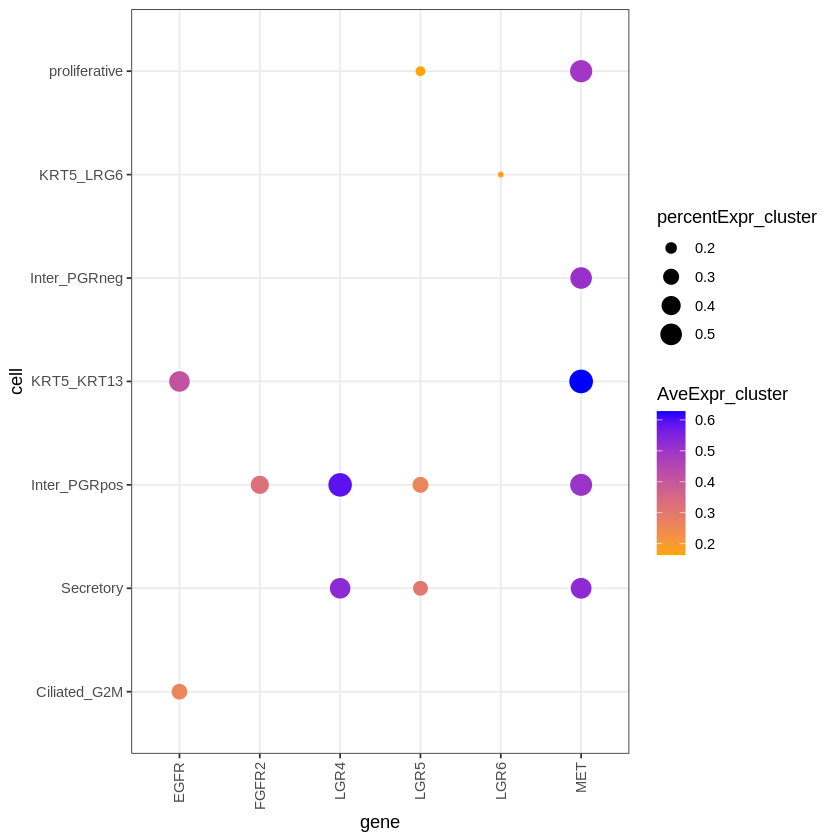

In [130]:
# filter genes
df = subset(cells2genes, ! gene %in% genes2plot)
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))
ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplotReceptorsMedia.pdf', dpi = 300, width = 6, height = 4)

## Load results between organoid cells

In [131]:
CPresults = read.csv('data/cellphoneDB_organoids_NI/out/DEapproach_results_pval0.001_logFC0.csv', stringsAsFactors = F)
rownames(CPresults) = CPresults$X
CPresults = CPresults[, -1]
colnames(CPresults) = gsub('\\...', '--', colnames(CPresults))
head(CPresults)

,Ciliated--Ciliated_G2M,Ciliated--Inter_PGRneg,Ciliated--Inter_PGRpos,Ciliated--KRT5_KRT13,Ciliated--KRT5_LRG6,Ciliated--proliferative,Ciliated--Secretory,Ciliated_G2M--Inter_PGRneg,Ciliated_G2M--Inter_PGRpos,Ciliated_G2M--KRT5_KRT13,⋯,Secretory--Inter_PGRpos,KRT5_LRG6--KRT5_KRT13,proliferative--KRT5_KRT13,Secretory--KRT5_KRT13,Media--KRT5_LRG6,proliferative--KRT5_LRG6,Secretory--KRT5_LRG6,proliferative--Media,Secretory--Media,Secretory--proliferative
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
IGF2_IGF1R,1,1,1,1,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IGF2_IGF2R,1,1,1,1,1,1,1,0,0,1,⋯,0,1,1,1,0,0,0,0,0,0
NOTCH1_JAG1,1,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
CD46_JAG1,1,1,1,1,1,1,1,1,1,1,⋯,1,0,0,1,0,0,1,0,0,1
NOTCH1_JAG2,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,1,1,0,0,0
NOTCH2_JAG2,1,0,1,1,1,0,0,0,0,0,⋯,0,0,0,0,0,1,1,0,0,0


# Dotplot1

Dot Plot 1: Receptor in the epithelial subsets

FZDx
LRP5
LRP6
LRG4
LRG5
LRG5


### Load genes of interest

In [132]:
genes2plot = read.csv('data/cellphoneDB/genes2plot/dotplot1.txt', stringsAsFactors = F, sep = '\t', header = F)$V1
genes2plot

[1] "LRP5"    "LRP6"    "LGR4"    "LGR5"    "LGR6"    "FZD1"    "FZD2"   
 [8] "FZD3"    "FZD4"    "FZD5"    "FZD6"    "FZD7"    "FZD8"    "FZD9"   
[15] "FZD10"   "KREMEN1" "KREMEN2"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [133]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
cells2genes$value = 1
cells2genes$gene = as.character(cells2genes$gene)
cells2genes$cell = as.character(cells2genes$cell)
 
head(cells2genes)

,cell,gene,id,AveExpr_cluster,percentExpr_cluster,value
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Ciliated,LRP5,Ciliated LRP5,0.258369,0.2740,1
2,Ciliated,FZD1,Ciliated FZD1,0.151295,0.1680,1
4,Ciliated,LRP6,Ciliated LRP6,0.189842,0.2060,1
6,Ciliated,FZD6,Ciliated FZD6,0.527070,0.5145,1
17,Ciliated,KREMEN1,Ciliated KREMEN1,0.138370,0.1505,1
26,Ciliated,FZD3,Ciliated FZD3,0.340019,0.3525,1


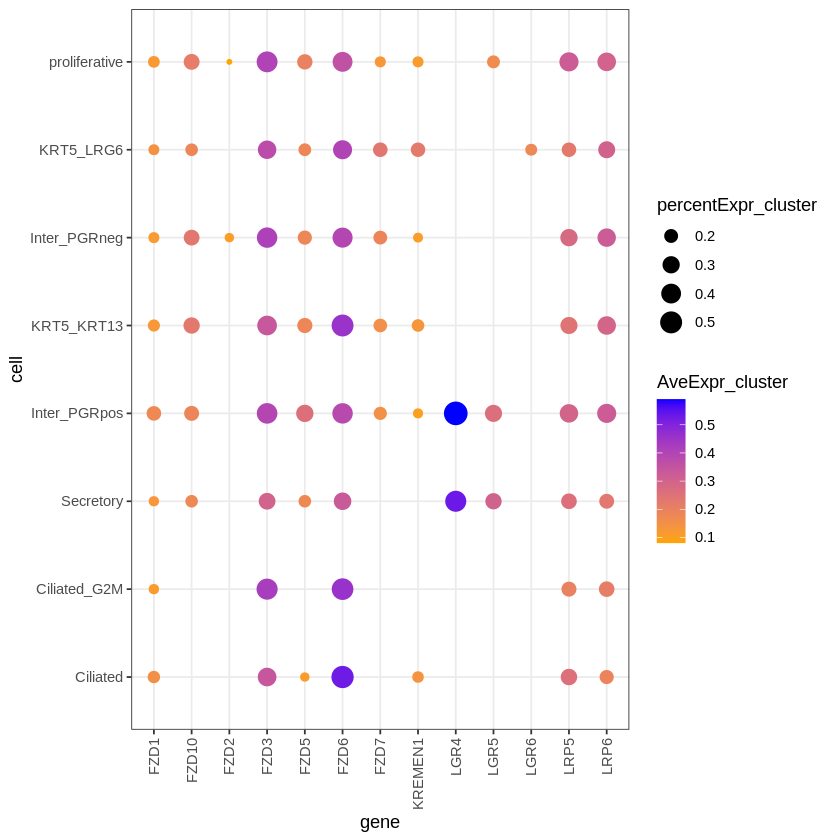

In [134]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ignore Media
df = df[ grep('Media', df$cell, invert = T) ,]
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))
ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplot1.pdf', dpi = 300, width = 6, height = 4)

# Dotplot2

Dot Plot 2: Ligand in the epithelial subsets + fibroblasts/stromal subets + immune subsets 
WNT
DKK1 - antagonist
KREMEN1 - co-receptor for DKK1
KREMEN2 - co-receptor for DKK1
WIF1 - soluble with WNT & inhibits
SFRP all -  soluble with WNT & inhibits
CER1 -  soluble with WNT & inhibits
NDP - WNT antagonist
SOSTDC1 - WNT antagonist
RSPO


### Load genes of interest

In [135]:
genes2plot = read.csv('data/cellphoneDB/genes2plot/dotplot2.txt', stringsAsFactors = F, sep = '\t', header = F)$V1
genes2plot

[1] "WNT1"    "WNT2"    "WNT2B"   "WNT3"    "WNT3A"   "WNT4"    "WNT5A"  
 [8] "WNT5B"   "WNT6"    "WNT7A"   "WNT7B"   "WNT8A"   "WNT8B"   "WNT9A"  
[15] "WNT9B"   "WNT10A"  "WNT10B"  "WNT11"   "WNT16"   "DKK1"    "WIF1"   
[22] "SFRP"    "CER1"    "NDP"     "SOSTDC1" "RSPO1"   "RSPO2"   "RSPO3"  
[29] "RSPO4"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [136]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
 
cells2genes$gene = as.character(cells2genes$gene)

,cell,gene,id,AveExpr_cluster,percentExpr_cluster
,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,Ciliated,LRP5,Ciliated LRP5,0.258369,0.2740
2,Ciliated,FZD1,Ciliated FZD1,0.151295,0.1680
4,Ciliated,LRP6,Ciliated LRP6,0.189842,0.2060
6,Ciliated,FZD6,Ciliated FZD6,0.527070,0.5145
17,Ciliated,KREMEN1,Ciliated KREMEN1,0.138370,0.1505
26,Ciliated,FZD3,Ciliated FZD3,0.340019,0.3525


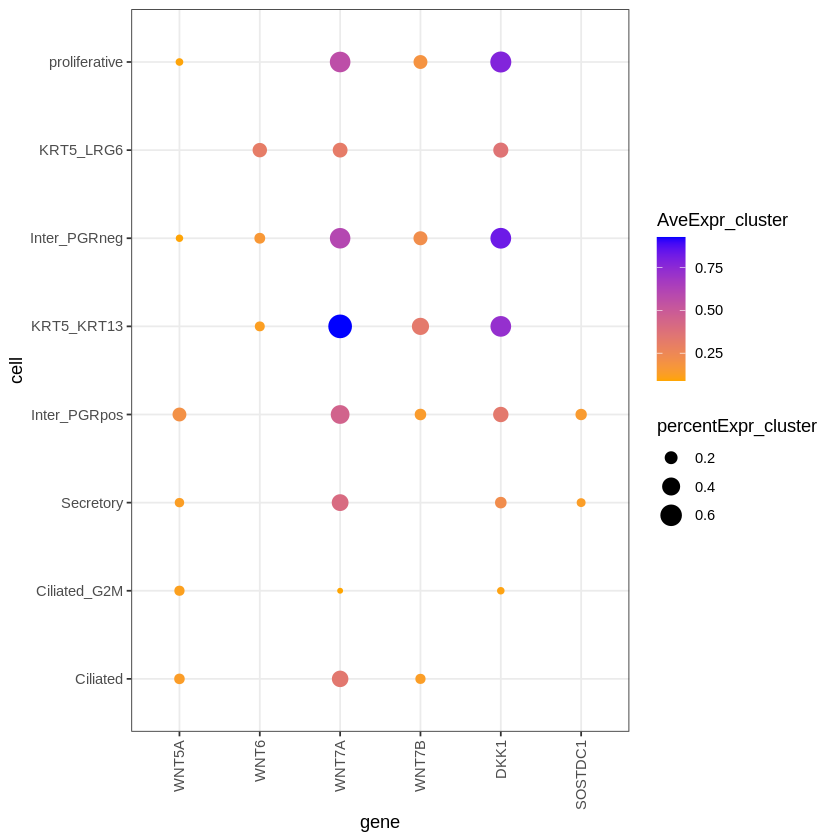

In [137]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ignore Media
df = df[ grep('Media', df$cell, invert = T) ,]
df$gene = factor(df$gene, levels = c(grep('WNT', sort(unique(df$gene)), value = T),
                                    grep('WNT', sort(unique(df$gene)), value = T, invert = T)) )
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))
ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplot2.pdf', dpi = 300, width = 6, height = 4)

# Dotplot3

Dot Plot 3: Notch receptors in the epithelial subsets
NOTCH1
NOTCH2
NOTCH3
NOTCH4



### Load genes of interest

In [138]:
genes2plot = read.csv('data/cellphoneDB/genes2plot/dotplot3.txt', stringsAsFactors = F, sep = '\t', header = F)$V1
genes2plot

[1] "NOTCH1" "NOTCH2" "NOTCH3" "NOTCH4"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [139]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cell,gene,id,AveExpr_cluster,percentExpr_cluster
,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,Ciliated,NOTCH1,Ciliated NOTCH1,0.093208,0.103000
2,Ciliated,NOTCH2,Ciliated NOTCH2,0.330544,0.336500
3,Ciliated,DLL1,Ciliated DLL1,0.130702,0.135500
4,Ciliated,JAG1,Ciliated JAG1,0.827517,0.688000
26,Ciliated,NOTCH3,Ciliated NOTCH3,0.203410,0.220000
42,Ciliated_G2M,JAG1,Ciliated_G2M JAG1,0.994830,0.816208


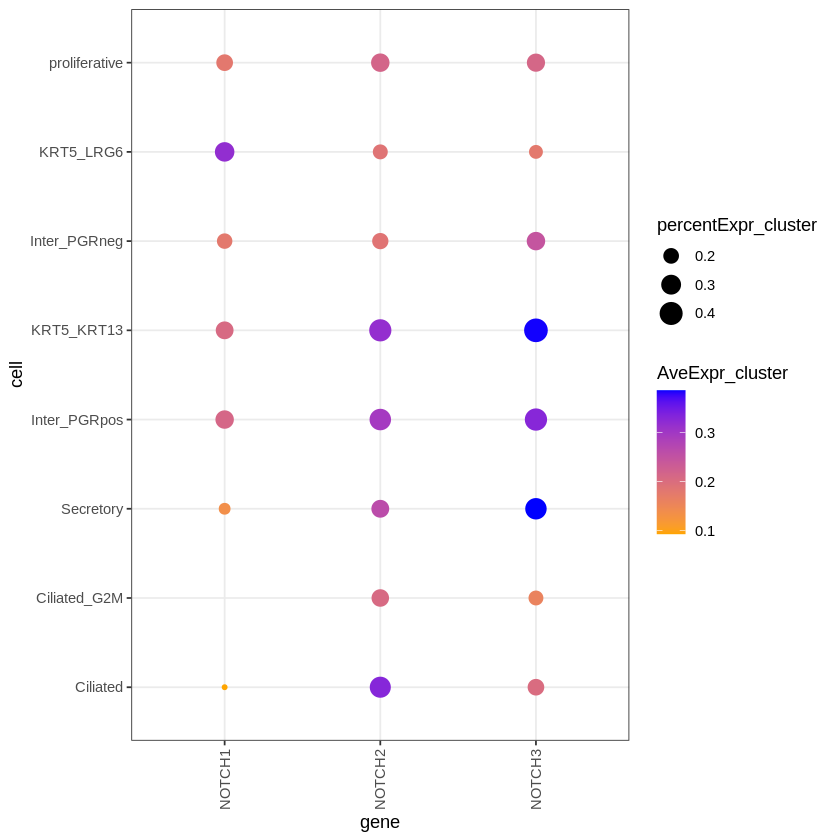

In [140]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ignore Media
df = df[ grep('Media', df$cell, invert = T) ,]
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))

ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplot3.pdf', dpi = 300, width = 5, height = 4)

# Dotplot4

Dot Plot 4: Notch ligands.  Ligand in the epithelial subsets + fibroblasts/stromal subets + immune subsets 
DLL1
DLL3
DLL4
JAG1
JAG2


### Load genes of interest

In [141]:
genes2plot = read.csv('data/cellphoneDB/genes2plot/dotplot4.txt', stringsAsFactors = F, sep = '\t', header = F)$V1
genes2plot

[1] "DLL1" "DLL3" "DLL4" "JAG1" "JAG2"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [142]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cell,gene,id,AveExpr_cluster,percentExpr_cluster
,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,Ciliated,NOTCH1,Ciliated NOTCH1,0.093208,0.1030
2,Ciliated,CD46,Ciliated CD46,1.240782,0.9110
3,Ciliated,NOTCH2,Ciliated NOTCH2,0.330544,0.3365
4,Ciliated,DLL1,Ciliated DLL1,0.130702,0.1355
5,Ciliated,JAG1,Ciliated JAG1,0.827517,0.6880
31,Ciliated,NOTCH3,Ciliated NOTCH3,0.203410,0.2200


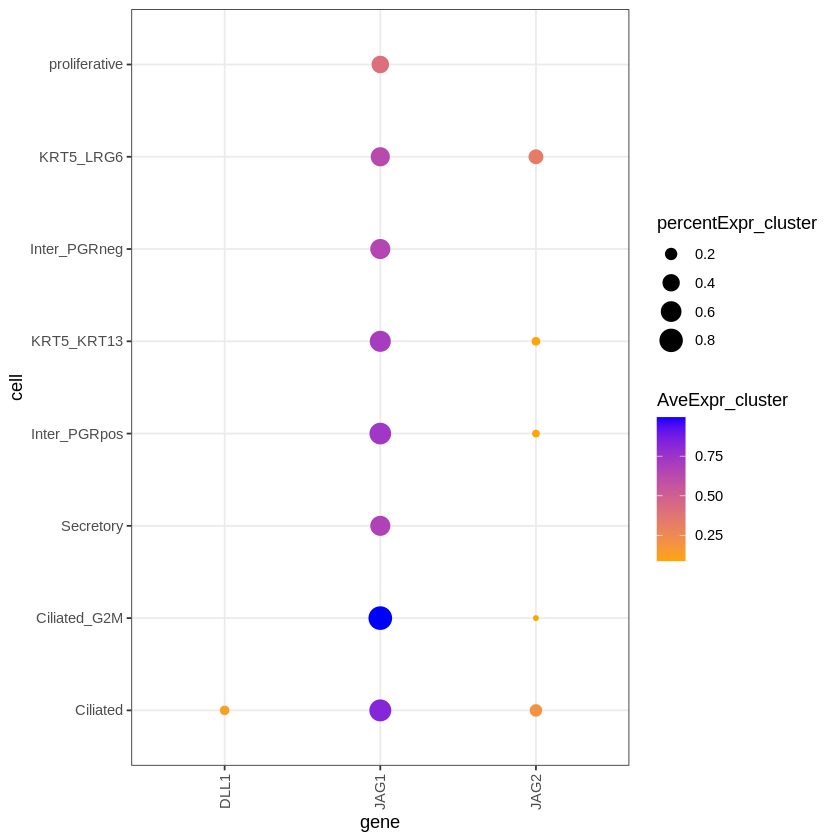

In [143]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ignore Media
df = df[ grep('Media', df$cell, invert = T) ,]
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))

ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplot4.pdf', dpi = 300, width = 4.5, height = 4)

# Dotplot5

Dot Plot 5: Small molecule receptors  in the epithelial subsets
PGR
ESR1
RARRES



### Load genes of interest

In [144]:
genes2plot = read.csv('data/cellphoneDB/genes2plot/dotplot5.txt', stringsAsFactors = F, sep = '\t', header = F)$V1
genes2plot

[1] "PGR"     "ESR1"    "RARRES1" "RARRES2"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [145]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cell,gene,id,AveExpr_cluster,percentExpr_cluster
,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,Ciliated,DHRS9,Ciliated DHRS9,0.560062,0.434000
2,Ciliated,STS,Ciliated STS,0.312108,0.309500
11,Ciliated_G2M,STS,Ciliated_G2M STS,0.198539,0.222458
17,Inter_PGRneg,HSD17B1,Inter_PGRneg HSD17B1,0.158654,0.166500
22,Inter_PGRpos,STS,Inter_PGRpos STS,0.096497,0.130000
23,Inter_PGRpos,HSD17B1,Inter_PGRpos HSD17B1,0.125217,0.150000


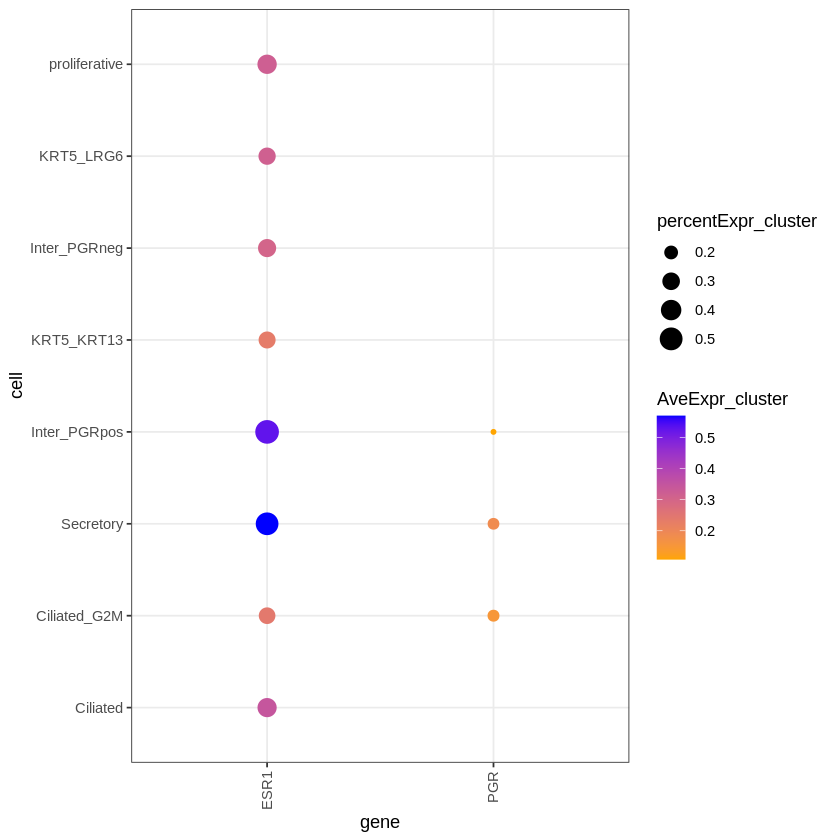

In [146]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ignore Media
df = df[ grep('Media', df$cell, invert = T) ,]
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))

ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplot5.pdf', dpi = 300, width = 4.5, height = 4)

# Receptors

receptors; FZD1-10; LRP5; LRP6; LRG4; LRG5; KREMEN; NOTCH1-4



### Load genes of interest

In [147]:
genes2plot = c(read.csv('data/cellphoneDB/genes2plot/dotplot1.txt', stringsAsFactors = F, sep = '\t', header = F)$V1,
               read.csv('data/cellphoneDB/genes2plot/dotplot3.txt', stringsAsFactors = F, sep = '\t', header = F)$V1)
genes2plot

[1] "LRP5"    "LRP6"    "LGR4"    "LGR5"    "LGR6"    "FZD1"    "FZD2"   
 [8] "FZD3"    "FZD4"    "FZD5"    "FZD6"    "FZD7"    "FZD8"    "FZD9"   
[15] "FZD10"   "KREMEN1" "KREMEN2" "NOTCH1"  "NOTCH2"  "NOTCH3"  "NOTCH4"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [148]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cell,gene,id,AveExpr_cluster,percentExpr_cluster
,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,Ciliated,NOTCH1,Ciliated NOTCH1,0.093208,0.1030
2,Ciliated,NOTCH2,Ciliated NOTCH2,0.330544,0.3365
3,Ciliated,DLL1,Ciliated DLL1,0.130702,0.1355
4,Ciliated,JAG1,Ciliated JAG1,0.827517,0.6880
7,Ciliated,LRP5,Ciliated LRP5,0.258369,0.2740
8,Ciliated,FZD1,Ciliated FZD1,0.151295,0.1680


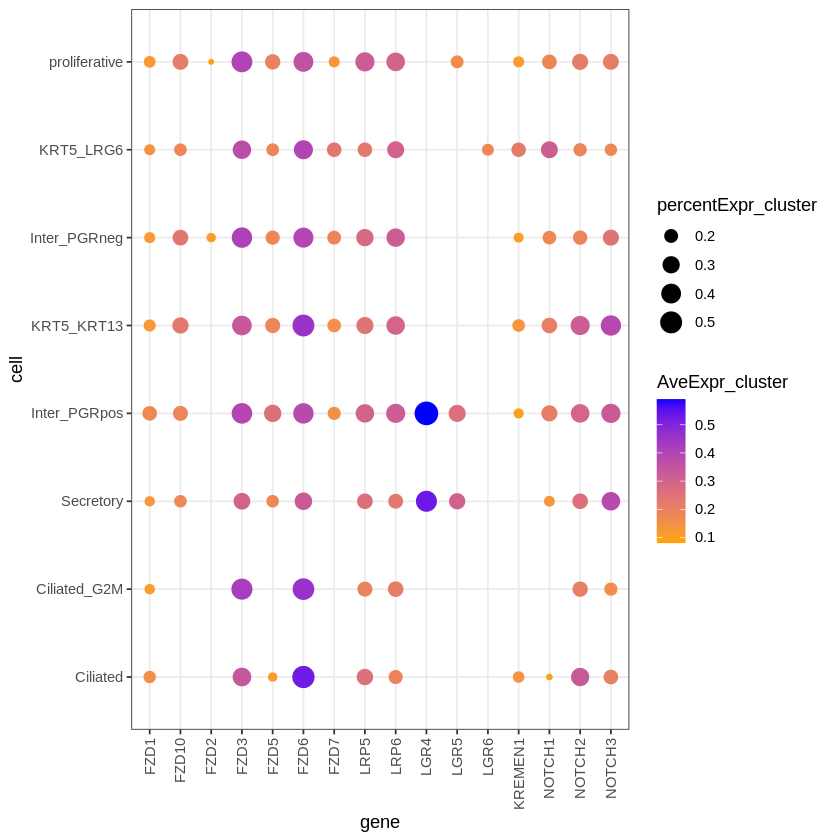

In [149]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ignore Media
df = df[ grep('Media', df$cell, invert = T) ,]
# ordre FZD1-10; LRP5; LRP6; LRG4; LRG5; KREMEN; NOTCH1-4
df$gene = factor(df$gene, levels = c(grep('FZD', sort(unique(df$gene)), value = T),
                                     grep('LRP', sort(unique(df$gene)), value = T),
                                     grep('LGR', sort(unique(df$gene)), value = T),
                                     grep('KREMEN', sort(unique(df$gene)), value = T),
                                     grep('NOTCH', sort(unique(df$gene)), value = T) ))
# ordre epi_prolife; LGR5; WIF1_1; WIF1_2; LYPD1; KRT5; LHX1
# df$cell = factor(df$cell, levels = rev(c('epithelial_proliferative', 'epithelial_LGR5', 
#                                      'epithelial_WIF1_1', 'epithelial_WIF1_2', 
#                                      'epithelial_LYPD1', 'epithelial_ciliated', 'epithelial_glandular') ))
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))

ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplotReceptors.pdf', dpi = 300, width = 7, height = 4)

# Ligands

 ligands: WNTxxxx; RSPO1; RSPO3; DKK1; WIF1; SOSTDC1; DLL1; DLL3; DLL4; JAG1; JAG2



### Load genes of interest

In [150]:
genes2plot = c(read.csv('data/cellphoneDB/genes2plot/dotplot2.txt', stringsAsFactors = F, sep = '\t', header = F)$V1,
               read.csv('data/cellphoneDB/genes2plot/dotplot4.txt', stringsAsFactors = F, sep = '\t', header = F)$V1)
genes2plot

[1] "WNT1"    "WNT2"    "WNT2B"   "WNT3"    "WNT3A"   "WNT4"    "WNT5A"  
 [8] "WNT5B"   "WNT6"    "WNT7A"   "WNT7B"   "WNT8A"   "WNT8B"   "WNT9A"  
[15] "WNT9B"   "WNT10A"  "WNT10B"  "WNT11"   "WNT16"   "DKK1"    "WIF1"   
[22] "SFRP"    "CER1"    "NDP"     "SOSTDC1" "RSPO1"   "RSPO2"   "RSPO3"  
[29] "RSPO4"   "DLL1"    "DLL3"    "DLL4"    "JAG1"    "JAG2"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [151]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)
 

,cell,gene,id,AveExpr_cluster,percentExpr_cluster
,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,Ciliated,NOTCH1,Ciliated NOTCH1,0.093208,0.1030
2,Ciliated,CD46,Ciliated CD46,1.240782,0.9110
3,Ciliated,NOTCH2,Ciliated NOTCH2,0.330544,0.3365
4,Ciliated,DLL1,Ciliated DLL1,0.130702,0.1355
5,Ciliated,JAG1,Ciliated JAG1,0.827517,0.6880
8,Ciliated,LRP5,Ciliated LRP5,0.258369,0.2740


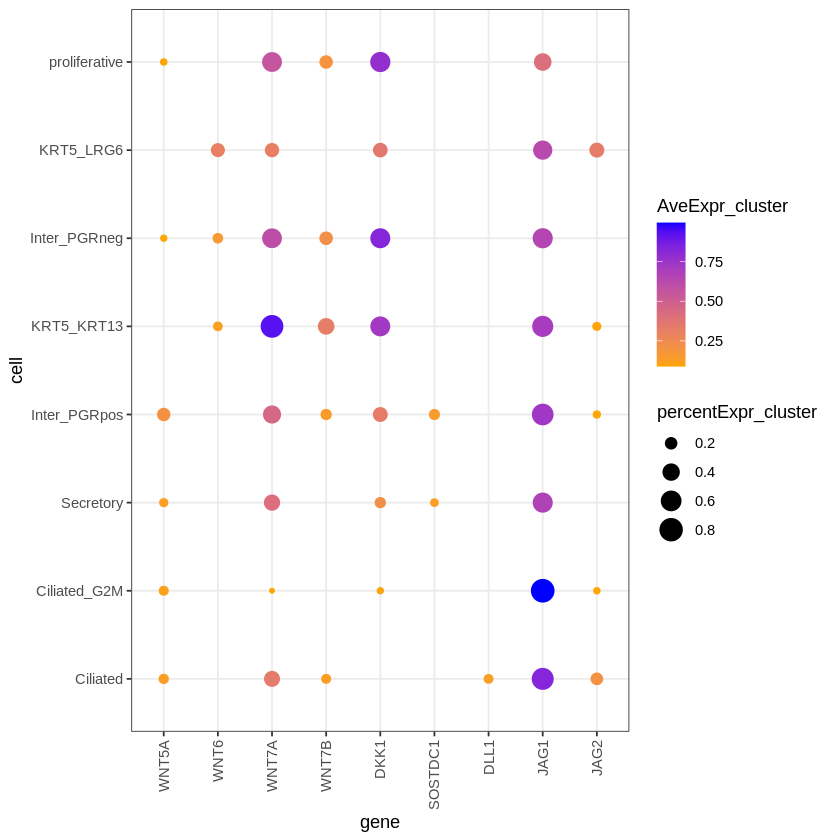

In [152]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ignore Media
df = df[ grep('Media', df$cell, invert = T) ,]
# ordre WNTxxxx; RSPO1; RSPO3; DKK1; WIF1; SOSTDC1; DLL1; DLL3; DLL4; JAG1; JAG2
df$gene = factor(df$gene, levels = c(grep('WNT', sort(unique(df$gene)), value = T),
                                     grep('RSP', sort(unique(df$gene)), value = T),
                                     'DKK1', 'WIF1', 'SOSTDC1',
                                     grep('DLL', sort(unique(df$gene)), value = T),
                                     grep('JAG', sort(unique(df$gene)), value = T) ))
# # ordre fibroblasts; stromal G2M; stomal eS G2M; eS; dS; T cell; myeloid
# df$cell = factor(df$cell, levels = rev(c('fibroblasts', 
#                                     'stromal_eS_G2M', 'stromal_eS_S-G2M', 'stromal_eS', 'stromal_dS', 
#                                     grep('epi', unique(df$cell), value = T),
#                                     'Tcell', 'myeloid')) )
# order cells
df$cell = factor(df$cell, levels = intersect(cells_order, df$cell))

ggplot(df,  aes(x = gene,
                    y = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave(filename = 'data/cellphoneDB_organoids_NI/out/dotplotLigands.pdf', dpi = 300, width = 6, height = 4)